# 2nd Homework - Data preprocessing and binary classification (deadline November 8th 23:59)

  * In this homework you have to handle features of various data types.
  * The features should be preprocessed and transformed to numeric representation, before training an ML model on the data.
  
> **Homework is assigned in a way that you have space for invention. Thinking of the _exact solution path_ is part of the assignment. Originality will be taken into account in the evaluation.**

## Data source

Your task is to predict the survival of Titanic passengers. Training data is in file **data.csv** and validation data in **evaluation.csv**.

### Features
* survived - 0 = No, 1 = Yes, **target variable**, 
* pclass - passenger's class, 1 = first, 2 = second, 3 = third
* name
* sex
* age - in years
* sibsp	- number of siblings / spouses onboard
* parch - number of parents / children onboard
* ticket - ticket number
* fare - ticket fare
* cabin	- cabin number
* embarked	- place of embarkment, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Home/destination

## Instructions

**Basic points of the assignment (8 points)**:
  * In the Jupyter notebook load **data.csv**. Split the data into subsets suitable for ML model training.
  * Explore and transform particular features into a format suitable for the selected classification method.
  * You can create new features (based on the existing ones), e.g. you can create a column with the length of the passenger's name. You can drop some features entirely too.
  * Handle the missing values in the dataset.
  * Select a suitable classification method from the lectures. Train it on the training set and tune the hyperparameters. Compute its accuracy on the training and validation set.
  * Load data from the file **evaluation.csv**. Compute predictions from these data (there are no target variable values in the file). Create a file **results.csv** and save your predictions into two columns - ID and the prediction of surviving. Upload this file alongside the Jupyter notebook to the repository.
  * Possible head of the file **results.csv**:
  
```
ID,survived
1000,0
1001,1
...
```
**Further points of assignment**, for possible more points (you can choose, maximum for the homework is 12):
  * (up to 4 points) Apply all of the classification methods discussed in the lectures to the problem. Select the best one based on the accuracy on the validation set. Use cross-validation to estimate the real accuracy of the best model. Use this model for prediction on the **evaluation.csv** data.
  * (up to 4 points) Try to use at least two advanced methods for filling missing values in the `age` feature. Explore the impact of these methods on the performance of the trained model. Use the method which you find to perform the best for the prediction on the **evaluation.csv** data.
  
## Submission notes

  * Follow instructions at https://courses.fit.cvut.cz/BIE-VZD/homeworks/index.html
  * Submit **Jupyter Notebook** (possibly with additional scripts) and file **results.csv** with the test predictions.
  * Reviewer may allow you to finish or correct your homework to achieve additional points. However, the first version is crucial.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

In [2]:
data = pd.read_csv('data.csv', index_col='ID')
display(data.head())
data.info()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,,,
0,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
1,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S,NaN
2,0,3,"Hegarty, Miss. Hanora ""Nora""",female,18.0,0,0,365226,6.7500,NaN,Q,NaN
3,0,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.5500,NaN,S,NaN
4,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   survived   1000 non-null   int64  
 1   pclass     1000 non-null   int64  
 2   name       1000 non-null   object 
 3   sex        1000 non-null   object 
 4   age        797 non-null    float64
 5   sibsp      1000 non-null   int64  
 6   parch      1000 non-null   int64  
 7   ticket     1000 non-null   object 
 8   fare       1000 non-null   float64
 9   cabin      226 non-null    object 
 10  embarked   998 non-null    object 
 11  home.dest  554 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 101.6+ KB


### Preparing the data

In [3]:
print('\nNumber of NaN values in the columns:')
data.isnull().sum(axis=0)


Number of NaN values in the columns:


survived       0
pclass         0
name           0
sex            0
age          203
sibsp          0
parch          0
ticket         0
fare           0
cabin        774
embarked       2
home.dest    446
dtype: int64

In [4]:
display(data[data['embarked'].isnull()][['name', 'embarked']])
data.groupby( 'embarked').describe()

,name,embarked
ID,,
218,"Stone, Mrs. George Nelson (Martha Evelyn)",NaN
346,"Icard, Miss. Amelie",NaN


survived                                              pclass  \
            count      mean       std  min  25%  50%  75%  max  count   
embarked                                                                
C           219.0  0.557078  0.497869  0.0  0.0  1.0  1.0  1.0  219.0   
Q            88.0  0.375000  0.486897  0.0  0.0  0.0  1.0  1.0   88.0   
S           691.0  0.341534  0.474568  0.0  0.0  0.0  1.0  1.0  691.0   

                    ... parch        fare                                \
              mean  ...   75%  max  count       mean        std     min   
embarked            ...                                                   
C         1.922374  ...   1.0  3.0  219.0  58.906604  77.285609  4.0125   
Q         2.875000  ...   0.0  5.0   88.0  12.833241  13.462257  6.7500   
S         2.367583  ...   0.0  9.0  691.0  27.714338  38.656831  0.0000   

                                               
             25%      50%       75%       max  
embarked                                       
C         13.825  27.7208  78.73335  512.3292  
Q          7.750   7.7646  12.35000   90.0000  
S          8.050  13.0000  27.82500  263.0000  

[3 rows x 48 columns]

In [5]:
# S - is the largest group from embarked feature, so lets change this 2 NaN's to S.
data['embarked'] = data['embarked'].fillna('S')
data['embarked'] = data['embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# In Age column we can replace Nan's by -1.
data['age'].fillna(data['age'].median(), inplace=True)
data['age'] = data['age'].astype(int)

# Creating new feature family_size
data['family_size'] = data['sibsp'] + data['parch'] + 1
data.drop( columns=['sibsp', 'parch'] )

# Label encoding of strings columns
object_dtype = data.select_dtypes(['object']).columns
data[object_dtype] = data[object_dtype].astype('category').apply(lambda x: x.cat.codes)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     1000 non-null   int64  
 1   pclass       1000 non-null   int64  
 2   name         1000 non-null   int16  
 3   sex          1000 non-null   int8   
 4   age          1000 non-null   int32  
 5   sibsp        1000 non-null   int64  
 6   parch        1000 non-null   int64  
 7   ticket       1000 non-null   int16  
 8   fare         1000 non-null   float64
 9   cabin        1000 non-null   int16  
 10  embarked     1000 non-null   int32  
 11  home.dest    1000 non-null   int16  
 12  family_size  1000 non-null   int64  
dtypes: float64(1), int16(4), int32(2), int64(5), int8(1)
memory usage: 71.3 KB


### Split the data

In [6]:
Xdata = data.drop(columns='survived')
ydata = data.survived 

rd_seed = 578
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
print(f"original data:   {Xdata.shape}")
print(f"train data:   {Xtrain.shape}")
print(f"validation data:   {Xvalid.shape}")
print(f"test data:   {Xtest.shape}")

original data:   (1000, 12)
train data:   (562, 12)
validation data:   (188, 12)
test data:   (250, 12)


# #1: Decision Tree

### Hyperparameter tuning - `max_depth` and `criterion`


In [7]:
param_grid = {
    'max_depth': range(1,50), 
    'criterion': ['entropy', 'gini']
    'random_state': [rd_seed]
}

In [8]:
param_comb = ParameterGrid(param_grid)
valid_acc = []
train_acc = []

for params in param_comb:
    tree_model = DecisionTreeClassifier(**params)
    tree_model.fit(Xtrain, ytrain)

    train_acc.append(metrics.accuracy_score(ytrain, tree_model.predict(Xtrain)))
    valid_acc.append(metrics.accuracy_score(yvalid, tree_model.predict(Xvalid)))


best hyperparameters:   {'max_depth': 5, 'criterion': 'entropy'}
training acc:   0.8434163701067615
validation acc:   0.8031914893617021


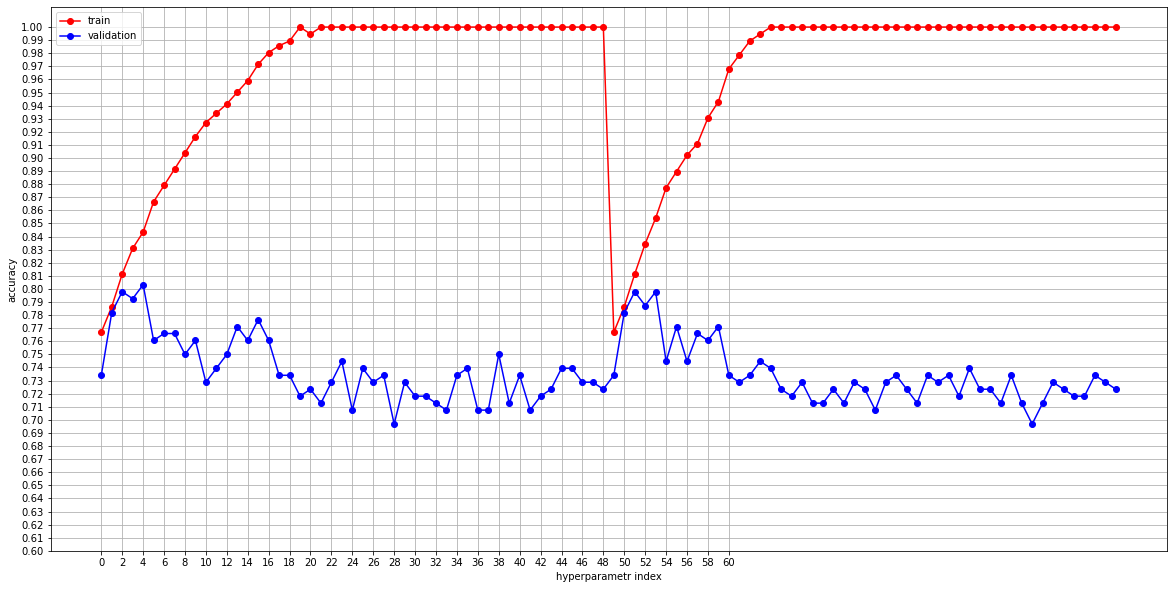

In [9]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(train_acc,'or-')
plt.plot(valid_acc,'ob-')
plt.yticks(np.arange(0.6, 1.01, step=0.01))
plt.xticks(np.arange(0, 61, step=2))
plt.grid()
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

best_params = param_comb[np.argmax(valid_acc)]
print(f"best hyperparameters:   {best_params}")
print(f"training acc:   {train_acc[np.argmax(valid_acc)]}")
print(f"validation acc:   {valid_acc[np.argmax(valid_acc)]}")

In [10]:
best_tree_model = DecisionTreeClassifier(**best_params)
best_tree_model.fit(Xtrain, ytrain)

valid_tree_acc = metrics.accuracy_score(yvalid, best_tree_model.predict(Xvalid));
train_tree_acc = metrics.accuracy_score(ytrain, best_tree_model.predict(Xtrain))
print('accuracy score (train): {0:.6f}'.format(train_tree_acc))
print('accuracy score (validation): {0:.6f}'.format(valid_tree_acc))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, best_tree_model.predict(Xtest))))

accuracy score (train): 0.843416
accuracy score (validation): 0.797872
accuracy score (test): 0.796000


In [11]:
# dt.predict(Xtest)

# #2 Random Forest

In [12]:
param_grid = {
    'n_estimators': range(1, 100, 5),
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 5),
    'criterion': ['gini', 'entropy'],
    'random_state': [rd_seed]
}

In [13]:
param_comb = ParameterGrid(param_grid)

train_acc.clear()
valid_acc.clear()
for params in param_comb:
    forest_model = RandomForestClassifier(**params).fit(Xtrain, ytrain)
    
    train_acc.append(metrics.accuracy_score(ytrain, forest_model.predict(Xtrain)))
    valid_acc.append(metrics.accuracy_score(yvalid, forest_model.predict(Xvalid)))

In [14]:
best_params = param_comb[np.argmax(valid_acc)]
print(f"best hyperparameters:   {best_params}")
print(f"max training acc:   {train_acc[np.argmax(train_acc)]}")
print(f"max validation acc:   {valid_acc[np.argmax(valid_acc)]}")

best hyperparameters:   {'random_state': 578, 'n_estimators': 46, 'min_samples_split': 3, 'max_depth': 7, 'criterion': 'gini'}
max training acc:   0.9537366548042705
max validation acc:   0.8138297872340425


In [15]:
best_forest_model = RandomForestClassifier(**best_params)
best_forest_model.fit(Xtrain, ytrain)

valid_forest_acc = metrics.accuracy_score(yvalid, best_forest_model.predict(Xvalid));
train_forest_acc = metrics.accuracy_score(ytrain, best_forest_model.predict(Xtrain))
print('accuracy score (train): {0:.6f}'.format(train_forest_acc))
print('accuracy score (validation): {0:.6f}'.format(valid_forest_acc))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, best_forest_model.predict(Xtest))))

accuracy score (train): 0.903915
accuracy score (validation): 0.813830
accuracy score (test): 0.824000


# #3 AdaBoost

### Performance comparison

We will plot the results and take the best model based on the accuracy score.


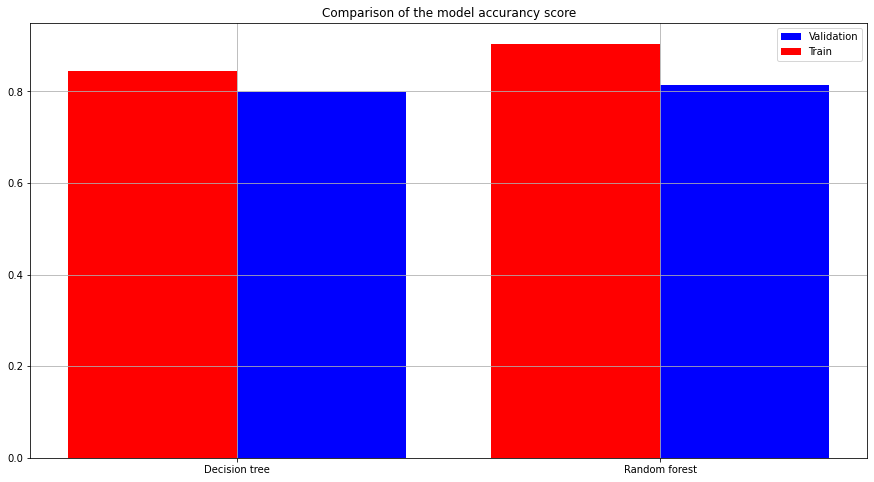

In [16]:
results_val = [valid_tree_acc, valid_forest_acc]
results_train = [train_tree_acc, train_forest_acc]

x_points_train = np.arange(len(results_val))
x_points_val = np.arange(0.4, len(results_val) + 0.4, 1)
x_points_labels = np.arange(0.2, len(results_val) + 0.2, 1)

plt.figure(figsize=(15,8))
plt.grid()
plt.bar(x_points_val, results_val, label='Validation', color='b', width=0.4)
plt.bar(x_points_train, results_train, label='Train', color='r', width=0.4)
plt.xticks(x_points_labels, ["Decision tree", "Random forest", "AdaBoost"])
plt.title("Comparison of the model accurancy score")
plt.legend()
plt.show()